# Q8
This assignment covers Hough transform.

## Lane Detection

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.

The algorithm can broken down into the following steps:
1. Detect edges using the Canny edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.



### 1. Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

Note : import Canny function which implement in Q5.ipnyb.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [6]:
from collections import deque
def conv(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    for i in range(Hi):
        for j in range(Wi):
            region_of_interest = padded[i:i+Hk, j:j+Wk]

            out[i, j] = np.sum(region_of_interest * kernel)

    return out


def gaussian_kernel(size, sigma):
    filter_values = np.zeros((size, size))
    delta = (size-1) / 2

    ### YOUR CODE HERE
    for i in range(size):
      for j in range(size):
          x = i - delta
          y = j - delta
          filter_values[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp(- (x**2 + y**2) / (2 * sigma**2))
    ### END YOUR CODE

    return filter_values
def partial_x(img):
    """ Computes partial x-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W)
    Returns:
        out: x-derivative image
    """

    out = None

    ### YOUR CODE HERE
    # Define the kernel for partial x-derivative
    kernel_dx = np.array([[-1, 0, 1]]) / 2

    # Compute the x-derivative using convolution
    out = conv(img, kernel_dx)
    ### END YOUR CODE

    return out

def partial_y(img):
    """ Computes partial y-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W)
    Returns:
        out: y-derivative image
    """

    out = None

    ### YOUR CODE HERE
    # Define the kernel for partial y-derivative
    kernel_dy = np.array([[-1], [0], [1]]) / 2

    # Compute the y-derivative using convolution
    out = conv(img, kernel_dy)
    ### END YOUR CODE

    return out


def gradient(img):
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    ### YOUR CODE HERE
    # Compute the partial derivatives in x and y directions
    G_x = partial_x(img)
    G_y = partial_y(img)

    # Compute magnitude of the gradient
    G = np.sqrt(G_x**2 + G_y**2)

    # Compute direction of the gradient
    theta = np.arctan2(G_y, G_x) * (180 / np.pi)  # Convert radians to degrees
    theta[theta < 0] += 360  # Ensure theta is in the range [0, 360)
    ### END YOUR CODE

    return G, theta

def non_maximum_suppression(G, theta):
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45

    ### BEGIN YOUR CODE
    for i in range(1, H - 1):
        for j in range(1, W - 1):
            # Identify the direction of the gradient
            direction = theta[i, j]

            # Initialize comparison pixels
            if direction == 0 or direction == 180:
                pixel_1, pixel_2 = G[i, j-1], G[i, j+1]
            elif direction == 45 or direction == 225:
                pixel_1, pixel_2 = G[i-1, j+1], G[i+1, j-1]
            elif direction == 90 or direction == 270:
                pixel_1, pixel_2 = G[i-1, j], G[i+1, j]
            elif direction == 135 or direction == 315:
                pixel_1, pixel_2 = G[i-1, j-1], G[i+1, j+1]

            # Preserve the value if it's a local maximum
            if G[i, j] >= max(pixel_1, pixel_2):
                out[i, j] = G[i, j]

    ### END YOUR CODE

    return out

def double_thresholding(img, high, low):
    strong_edges = np.zeros(img.shape)
    weak_edges = np.zeros(img.shape)

    ### YOUR CODE HERE
    strong_edges = img > high
    weak_edges = (img <= high) & (img >= low)
    ### END YOUR CODE

    return strong_edges, weak_edges


def link_edges(strong_edges, weak_edges):

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W))
    ### YOUR CODE HERE
    # Define visited array to keep track of visited pixels during BFS
    visited = np.zeros((H, W), dtype=bool)

    # Define offsets for neighboring pixels
    offsets = [(dy, dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1] if (dy, dx) != (0, 0)]

    # Perform BFS for each strong edge pixel
    for y, x in indices:
        if not visited[y, x]:
            visited[y, x] = True
            edges[y, x] = 1  # Mark strong edge

            # Initialize queue for BFS
            queue = deque([(y, x)])

            while queue:
                cy, cx = queue.popleft()

                # Iterate over neighboring pixels
                for dy, dx in offsets:
                    ny, nx = cy + dy, cx + dx

                    # Check if neighbor is within bounds and not visited
                    if 0 <= ny < H and 0 <= nx < W and not visited[ny, nx]:
                        visited[ny, nx] = True

                        # If the neighbor is a weak edge, mark it as an edge
                        if weak_edges[ny, nx]:
                            edges[ny, nx] = 1
                            queue.append((ny, nx))

    ### END YOUR CODE

    return edges

def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    ### YOUR CODE HERE
    # Step 1: Apply Gaussian smoothing
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed_img = conv(img, kernel)

    # Step 2: Compute gradients
    G, T = gradient(smoothed_img)

    # Step 4: Non-maximum suppression
    nms_img = non_maximum_suppression(G, T)

    # Step 5: Double thresholding
    strong_edges, weak_edges = double_thresholding(nms_img, high, low)

    # Step 6: Link weak edges to strong edges
    edges = link_edges(strong_edges, weak_edges)
    ### END YOUR CODE

    return edges

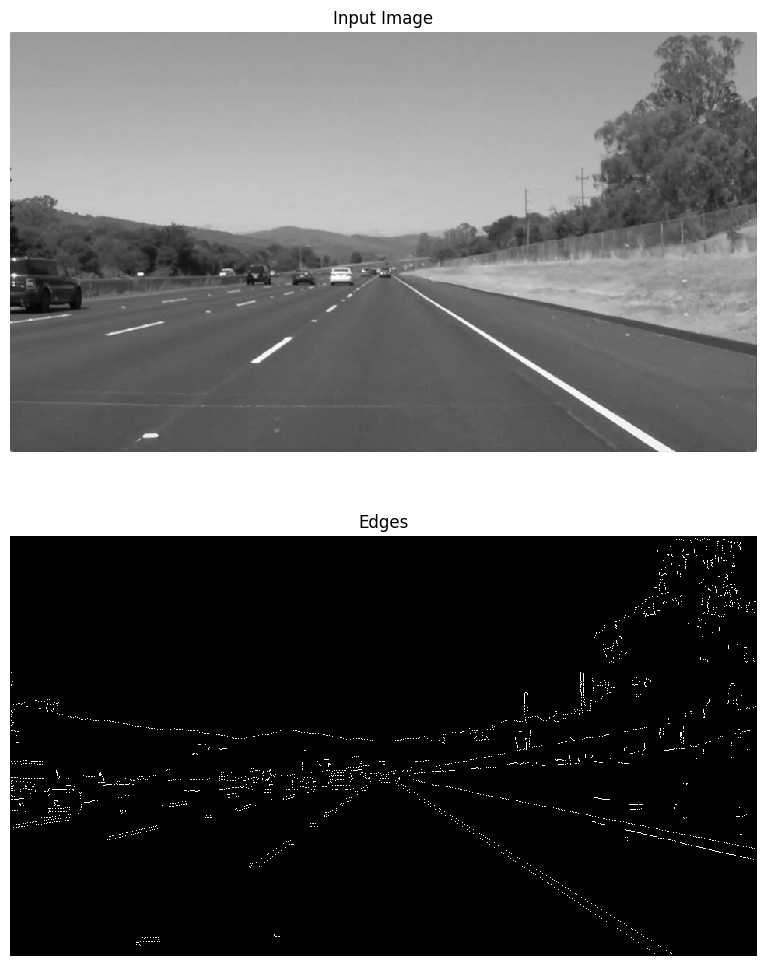

In [7]:
# import canny from Q5

# Load image
img = io.imread('road.jpg', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 2. Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

129091


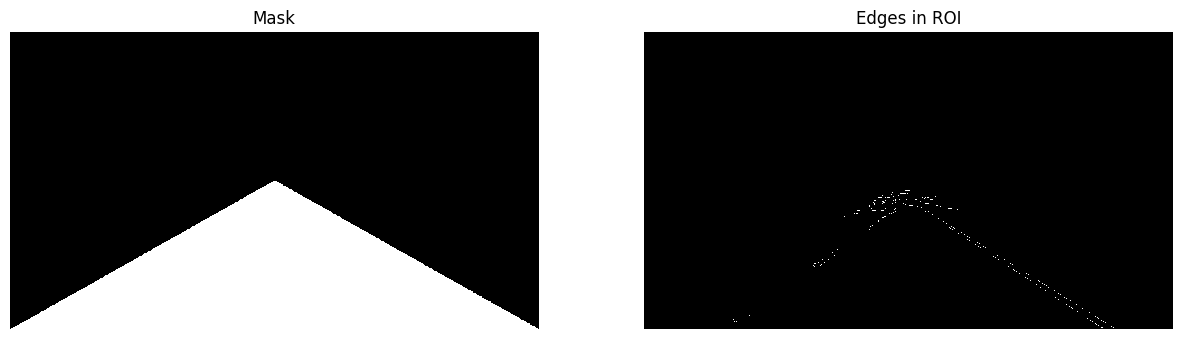

In [8]:
H, W = img.shape
# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
cnt = 0
for i in range(H):
    for j in range(W):

        if i > (float(H) / float(W)) * j and i > -(float(H) / W) * j + H:
            cnt += 1
            mask[i, j] = 1
print (cnt)
# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 3. Fitting lines using Hough transform
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map everypoint in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

*See [notes](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) on Hough transform.*

Implement **`hough_transform`**.

In [15]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.

    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.

    Args:
        img: binary image of shape (H, W).

    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, 2 * diag_len + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)

    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordinate.
    ### YOUR CODE
    # Iterate through each edge pixel
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        # Compute rho for each theta
        for t_idx in range(num_thetas):
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            accumulator[rho, t_idx] += 1
    ### END YOUR CODE

    return accumulator, rhos, thetas

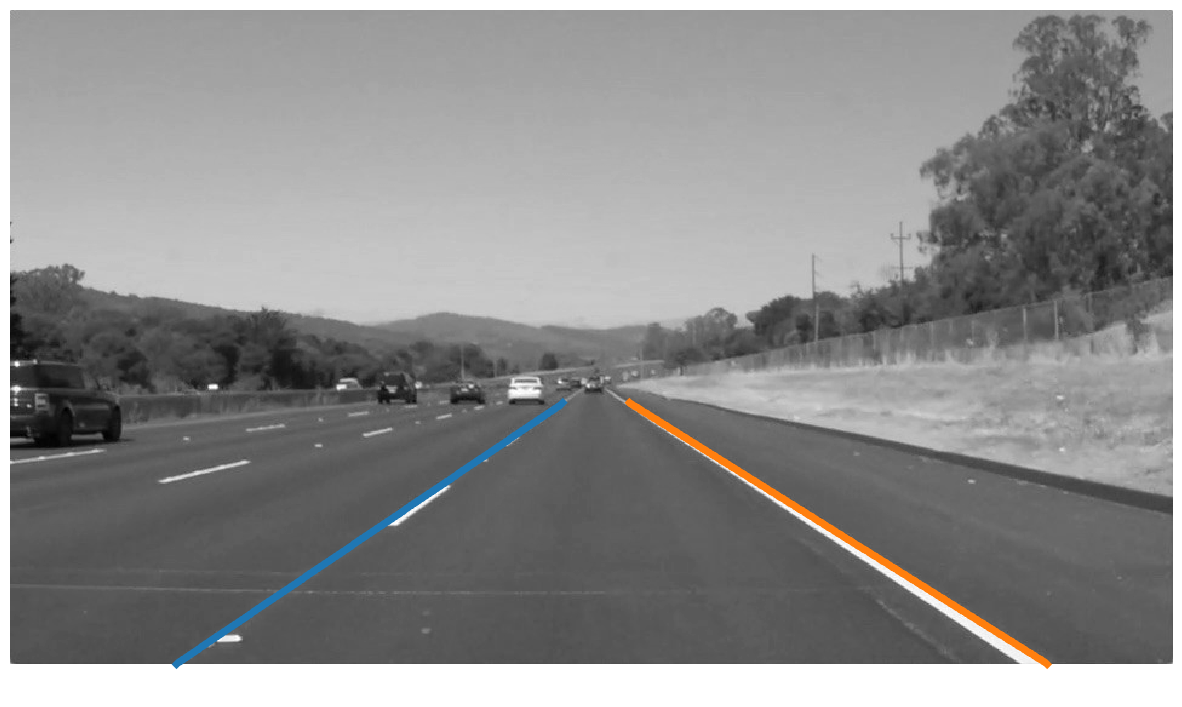

In [16]:
# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]

    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break

    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()